In [1]:
import os

import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Reshape, Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop

2025-10-25 17:26:58.570233: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761413218.850789      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761413218.931403      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load dataset

In [2]:
progress = tqdm(total=50)
df = pd.DataFrame()
for position in ["Belt", "Left-Pocket", "Right-Pocket", "Upper-Arm", "Wrist"]:
    for i in range(10, 0, -1):
        # print(f"{position} Participant {i}")
        url = f"/kaggle/input/utwente-shoaib/{position}/Participant_{i}.csv/Participant_{i}.csv"
        p_df = pd.read_csv(url)
        
        df = pd.concat([df, p_df])
        progress.update(1)
df = df.reset_index(drop=True)
progress.close()

feature_cols = ['Ax','Ay','Az','Gx','Gy','Gz']
X_raw = df[feature_cols].values
y_raw = df['Activity'].values.astype(int)

df

  0%|          | 0/50 [00:00<?, ?it/s]

,Ax,Ay,Az,Gx,Gy,Gz,Mx,My,Mz,Activity
0,9.3436,-3.2416,1.089600,0.830170,0.15302,-0.032681,-28.98,11.94,20.46,1
1,11.3460,-3.5413,0.027241,0.677760,0.16646,-0.094990,-28.92,12.66,20.34,1
2,14.2200,-4.7126,0.354130,0.265420,0.32590,-0.045509,-29.04,12.90,20.16,1
3,14.4510,-4.6582,0.354130,-0.009163,0.22388,-0.055894,-28.98,13.20,20.04,1
4,12.2580,-2.9284,-2.942000,-0.011606,-0.47342,-0.088881,-28.98,13.68,19.56,1
...,...,...,...,...,...,...,...,...,...,...
3149995,3.7728,-4.6445,-0.994290,0.378430,-0.17837,-0.659430,-17.28,24.84,-8.64,7
3149996,3.8409,-4.7671,-1.103200,0.436460,-0.42302,-0.562300,-17.40,24.72,-8.94,7
3149997,4.0044,-5.4073,-1.280300,0.453870,-0.64874,-0.423020,-17.70,24.54,-9.00,7
3149998,4.0589,-5.7478,-1.362000,0.431880,-0.81948,-0.292600,-17.94,24.48,-9.18,7


# Encode labels

In [3]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_raw)
y_onehot = to_categorical(y_encoded)

# Sliding windows

In [4]:
def create_windows(X, y, window_size=128, step_size=64):
    X_windows = []
    y_windows = []
    for start in range(0, len(X) - window_size + 1, step_size):
        end = start + window_size
        X_windows.append(X[start:end])
        # Majority vote label in window
        y_windows.append(np.bincount(y_encoded[start:end]).argmax())
    return np.array(X_windows), np.array(y_windows)

window_size = 128
step_size = 64
X_win, y_win = create_windows(X_raw, y_onehot, window_size, step_size)
y_win_onehot = to_categorical(y_win)

# Train/test/val split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X_win, y_win_onehot, test_size=0.2, random_state=42, stratify=y_win
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=np.argmax(y_train, axis=1)
)

# Prepare tf.data for GPU

In [6]:
batch_size = 512

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(2048).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

2025-10-25 17:27:19.654031: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# Build CNN model

In [7]:
model = Sequential([
    Input(shape=(window_size, len(feature_cols))),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.6),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(y_win_onehot.shape[1], activation='softmax')
])

optimizer = RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 126, 32)        │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 124, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 62, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 62, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1984)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        63,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,463 (263.53 KB)

 Trainable params: 67,463 (263.53 KB)

 Non-trainable params: 0 (0.00 B)

# Train model

In [8]:
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset
)

filename = "/kaggle/working/shoaib_har_cnn.keras"
model.save(filename)
print(os.path.getsize(filename) / 1024, "KB")

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.3859 - loss: 1.8545 - val_accuracy: 0.7153 - val_loss: 0.7264
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7178 - loss: 0.7093 - val_accuracy: 0.8475 - val_loss: 0.4378
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8011 - loss: 0.4987 - val_accuracy: 0.8655 - val_loss: 0.3805
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8357 - loss: 0.4113 - val_accuracy: 0.8349 - val_loss: 0.4285
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8654 - loss: 0.3498 - val_accuracy: 0.9063 - val_loss: 0.2692
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8838 - loss: 0.3029 - val_accuracy: 0.9180 - val_loss: 0.2492
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8982 - loss: 0.2792 - val_accuracy: 0.8751 - val_loss: 0.3165
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9102 - loss: 0.2412 - val_accuracy: 0.9445 - v

# Evaluate

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
              precision    recall  f1-score   support

     walking       0.98      0.97      0.97      1408
    standing       0.97      0.99      0.98      1406
     jogging       0.99      0.99      0.99      1406
     sitting       0.99      0.97      0.98      1406
      biking       0.99      0.99      0.99      1407
    upstairs       0.97      0.96      0.97      1406
  downstairs       0.96      0.99      0.98      1405

    accuracy                           0.98      9844
   macro avg       0.98      0.98      0.98      9844
weighted avg       0.98      0.98      0.98      9844



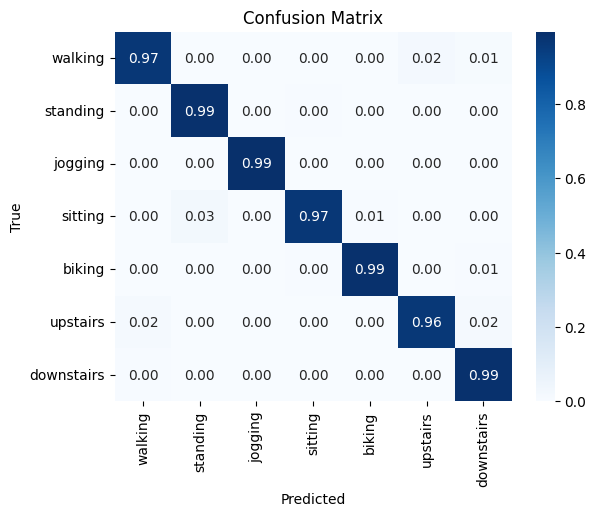

In [9]:
labels = ['walking', 'standing', 'jogging', 'sitting', 'biking', 'upstairs', 'downstairs']
y_pred_probs = model.predict(test_dataset)          # probabilities
y_pred = np.argmax(y_pred_probs, axis=1)          # predicted labels
y_true = np.argmax(y_test, axis=1)                # true labels
print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, None]
labels = ['walking', 'standing', 'jogging', 'sitting', 'biking', 'upstairs', 'downstairs']
sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, fmt=".2f", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Convert to TFLite

In [10]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Provide a representative dataset for calibration (important!)
def representative_data():
    for data in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
        yield [tf.cast(data, tf.float32)]

converter.representative_dataset = representative_data
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_quant_model = converter.convert()

filename = "/kaggle/working/shoaib_har_cnn_quant.tflite"
with open(filename, "wb") as f:
    f.write(tflite_quant_model)


print(os.path.getsize(filename) / 1024, "KB")

!echo "const unsigned char model[] = {" > /kaggle/working/shoaib_har_cnn_quant.h
!cat shoaib_har_cnn_quant.tflite | xxd -i      >> /kaggle/working/shoaib_har_cnn_quant.h
!echo "};"                              >> /kaggle/working/shoaib_har_cnn_quant.h

tf.lite.experimental.Analyzer.analyze(model_path=filename)

Saved artifact at '/tmp/tmpjroum_8v'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 6), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  135587031884880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135587031886416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135587031885264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135587031877008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135587031885840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135587031887376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135587031886608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135587031886224: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1761413355.056213      13 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1761413355.056284      13 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1761413355.061200      13 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


73.71875 KB


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


=== /kaggle/working/shoaib_har_cnn_quant.tflite ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the EXPAND_DIMS op takes
tensor #0 and tensor #1 as input and produces tensor #14 as output.

Subgraph#0 main(T#0) -> [T#25]
  Op#0 EXPAND_DIMS(T#0, T#1[-3]) -> [T#14]
  Op#1 CONV_2D(T#14, T#13, T#12[-19, -21, -104, -69, -153, ...]) -> [T#15]
  Op#2 RESHAPE(T#15, T#2[-1, 126, 32]) -> [T#16]
  Op#3 EXPAND_DIMS(T#16, T#1[-3]) -> [T#17]
  Op#4 CONV_2D(T#17, T#11, T#10[159, 370, -174, -310, 179, ...]) -> [T#18]
  Op#5 RESHAPE(T#18, T#3[-1, 124, 32]) -> [T#19]
  Op#6 EXPAND_DIMS(T#19, T#4[1]) -> [T#20]
  Op#7 MAX_POOL_2D(T#20) -> [T#21]
  Op#8 RESHAPE(T#21, T#5[-1, 1984]) -> [T#22]
  Op#9 FULLY_CONNECTED(T#22, T#9, T#8[-922, -1144, 595, 279, 658, ...]) -> [T#23]
  Op#10 FULLY_CONNECTED(T#23, T#7, T#6[-20, 66, -144, 82, -128, ...]) -> [T#24]
  Op#11 SOFTMAX(T#24) -> [T#25]

Tensors of Subgraph#0
  T#0(serv

# Evaluate TFLite

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


  0%|          | 0/9844 [00:00<?, ?it/s]

              precision    recall  f1-score   support

     walking       0.97      0.97      0.97      1408
    standing       0.97      0.99      0.98      1406
     jogging       0.99      1.00      0.99      1406
     sitting       0.99      0.97      0.98      1406
      biking       0.99      0.99      0.99      1407
    upstairs       0.97      0.96      0.97      1406
  downstairs       0.97      0.99      0.98      1405

    accuracy                           0.98      9844
   macro avg       0.98      0.98      0.98      9844
weighted avg       0.98      0.98      0.98      9844



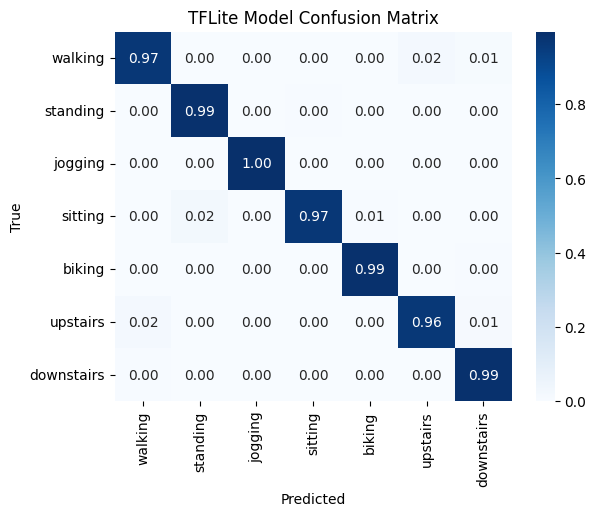

In [11]:
interpreter = tf.lite.Interpreter(model_path="/kaggle/working/shoaib_har_cnn_quant.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

scale, zero_point = input_details[0]['quantization']

y_tflite_pred = []

for i in tqdm(range(len(X_test))):
    # Quantize one sample
    x = np.round(X_test[i:i+1] / scale + zero_point).astype(np.int8)
    
    interpreter.set_tensor(input_details[0]['index'], x)
    interpreter.invoke()
    
    # Dequantize output (optional)
    yq = interpreter.get_tensor(output_details[0]['index'])
    y_tflite_pred.append(np.argmax(yq, axis=1)[0])

y_tflite_pred = np.array(y_tflite_pred)

print(classification_report(y_true, y_tflite_pred, target_names=labels))

cm = confusion_matrix(y_true, y_tflite_pred)
cm = cm / cm.sum(axis=1)[:, None]
sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, fmt=".2f", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('TFLite Model Confusion Matrix')
plt.show()